In [1]:
from datetime import datetime
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi15.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves based on user input dates
def predict_heatwave_for_dates(dates):
    new_data = data.loc[dates]
    new_data_scaled = scaler.transform(new_data[features])
    
    # Create sequences from the new data
    new_sequences = []
    for i in range(len(new_data_scaled) - seq_length):
        seq = new_data_scaled[i:i + seq_length]
        new_sequences.append(seq)
    
    new_sequences = np.array(new_sequences)
    
    # Predict heatwaves
    new_predictions = model.predict(new_sequences)
    new_predicted_labels = (new_predictions > 0.5).astype(int).flatten()
    
    result = pd.DataFrame({
        'date': new_data.index[seq_length:],
        'tempmax': new_data['tempmax'][seq_length:],
        'temp': new_data['temp'][seq_length:],
        'humidity': new_data['humidity'][seq_length:],
        'predicted_heatwave': new_predicted_labels
    })
    
    result['heatwave'] = result['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    return result

# Example usage with user input dates
user_dates = pd.date_range(start='2024-06-16', end='2024-06-25')
prediction_result = predict_heatwave_for_dates(user_dates)
print(prediction_result)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.6852 - val_accuracy: 1.0000 - val_loss: 0.6739
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.6773 - val_accuracy: 1.0000 - val_loss: 0.6661
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.6739 - val_accuracy: 1.0000 - val_loss: 0.6578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.6673 - val_accuracy: 1.0000 - val_loss: 0.6496
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.6514 - val_accuracy: 1.0000 - val_loss: 0.6413
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6481 - val_accuracy: 1.0000 - val_loss: 0.6330
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.6376 - val_accuracy: 1.0000 - val_loss: 0.6242
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.6335 - val_accuracy: 1.0000 - val_loss: 0

KeyError: "[Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00')] not in index"

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.0394 - val_accuracy: 1.0000 - val_loss: 0.6642
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6667 - loss: 0.8592 - val_accuracy: 1.0000 - val_loss: 0.6601
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5000 - loss: 0.7927 - val_accuracy: 1.0000 - val_loss: 0.6552
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5000 - loss: 0.9207 - val_accuracy: 1.0000 - val_loss: 0.6519
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5000 - loss: 0.9097 - val_accuracy: 1.0000 - val_loss: 0.6473
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 0.7641 - val_accuracy: 1.0000 - val_loss: 0.6438
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3333 - loss: 0.7952 - val_accuracy: 1.0000 - val_loss: 0.6397
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5000 - loss: 0.9268 - val_accuracy: 1.0000 - val_loss: 0

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
        date  predicted_heatwave heatwave
0 2024-06-23                   0       No
1 2024-06-24                   0       No
2 2024-06-25                   0       No
3 2024-06-26                   0       No
4 2024-06-27                   0       No


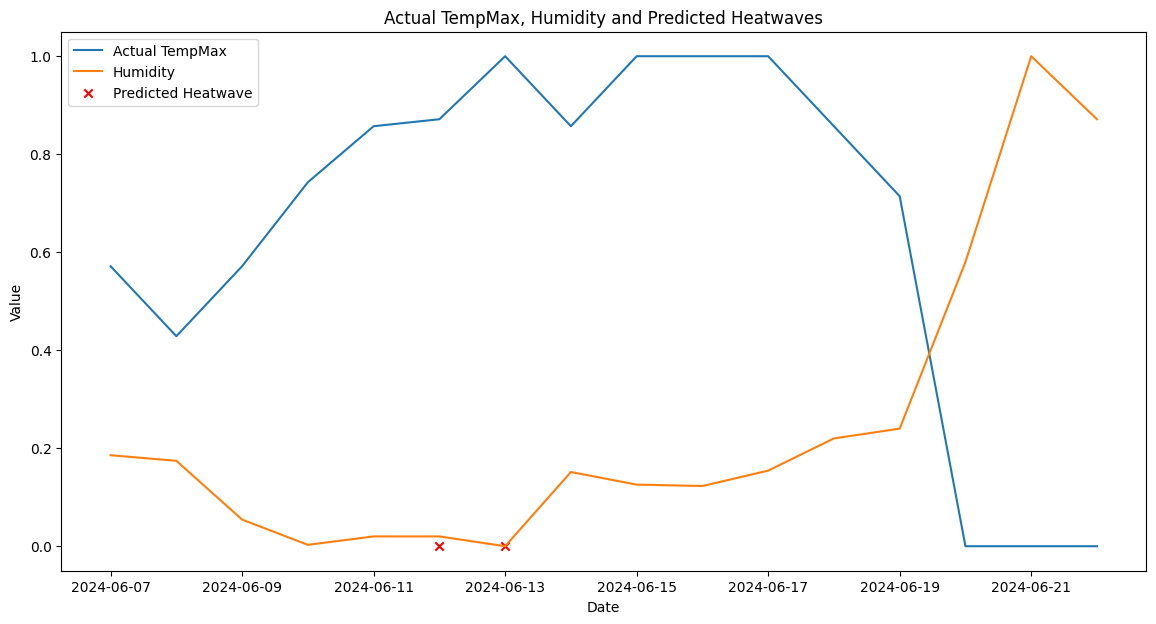

In [6]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi15.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


In [9]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi15.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%dd-%mm-%YYYY")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


KeyError: 'time'